In [1]:
import sys
import math

import numpy as np
from numpy.linalg import lstsq
from numpy import dot
import matplotlib.pyplot as plt

from scipy.cluster.vq import kmeans2, vq
from scipy.linalg import norm
from scipy.optimize import minimize
from sklearn.decomposition import NMF

import igraph
import networkx as nx

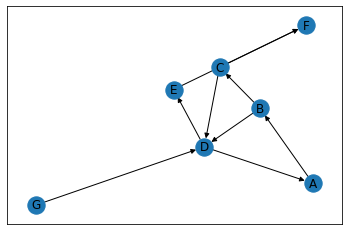

In [2]:
g = nx.DiGraph(directed=True)

g.add_edges_from([('A', 'B'),('C','D'),('G','D')], weight=1)
g.add_edges_from([('D','A'),('D','E'),('B','D'),('D','E')], weight=2)
g.add_edges_from([('B','C'),('E','F')], weight=3)
g.add_edges_from([('C','F')], weight=4)

pos = nx.get_node_attributes(g, 'pos')
labels = nx.get_edge_attributes(g,'weight')

nx.draw_networkx(g, arrows=True)
# _ = nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)
G = igraph.Graph.from_networkx(g)
# igraph.plot(G)

[Draw weighted directed graph](https://stackoverflow.com/questions/20133479/how-to-draw-directed-graphs-using-networkx-in-python)

In [3]:
G.degree()

[2, 3, 3, 5, 1, 2, 2]

In [11]:
def extract_rolx_roles(G, roles=2):
    """
    Top-level function. Extracts node-role matrix and sensemaking role-feature matrix as necessary.
    """

    # Feature grouping
    # Get recursive features for each vertex, and factorize V to obtain G(basis) and F(coef).
    # G: node's membership in each role
    # F: role's contrubution to each feature
    print("Creating Vertex/Node Features matrix")
    V = vertex_features(G)
    print("V is a %s by %s matrix." % V.shape)
    basis, coef = get_factorization(V, roles)

    H = basis
    print("Node-role matrix is of dimensions %s by %s" % H.shape)
    print(H)

    K = make_sense(G, H)
    print("Role-feature matrix is of dimensions %s by %s" % K.shape)
    print(K)

    return H, K

In [5]:
def recursive_feature(G, f, n):
    """
        G: iGraph graph with annotations
        func: string containing function name
        n: int, recursion level
        Computes the given function recursively on each vertex
        Current precondition: already have run the computation for G, func, n-1.
    """
    return np.matrix(recursive_feature_array(G,f,n))

def recursive_feature_array(G, func, n):
    """
    Computes recursive features of the graph G for the provided function of G, returning
    the matrix representing the nth level of the recursion.
    """
    attr_name = "_rolx_" + func.__name__ + "_" + str(n)

    if attr_name in G.vs.attributes():
        result = np.array(G.vs[attr_name])
        return result

    if n==0:
        stats = func(G)
        result = np.array([[x] for x in stats])
        result = result * 1.0 
        G.vs[attr_name] = result
        return result

    prev_stats = recursive_feature_array(G, func, n-1)
    all_neighbor_stats = []
    for v in G.vs:
        neighbors = G.neighbors(v)
        degree = len(neighbors)
        if degree == 0: 
            neighbor_avgs = neighbor_sums = np.zeros(prev_stats[0].size)
        else: 
            prev_neighbor_stats = [prev_stats[x] for x in neighbors]
            neighbor_sums_vec = sum(prev_neighbor_stats)
            neighbor_avgs_vec = neighbor_sums_vec / degree

        v_stats = np.concatenate((neighbor_sums_vec, neighbor_avgs_vec), axis=0)
        all_neighbor_stats.append(v_stats)

    G.vs[attr_name] = all_neighbor_stats
    return all_neighbor_stats

In [6]:
def add_col(V, b, insert_col):
    """ Add the given column b to the matrix V, enlarging the matrix if necessary. """ 
    rows, cols = V.shape
    if insert_col == cols: # need to resize V
        zeros = np.matrix(np.zeros((rows, 1)))
        V = np.concatenate((V, zeros), axis=1)
    V[:, insert_col] = b
    return V

def approx_linear_solution(w, A, threshold=1e-15):
    '''
    Checks if w is linearly dependent on the columns of A, this is done by solving the least squares problem (LSP)
        min || w - Ax ||_2^2
         x
    and checking if || w - Ax_star || <= threshold, where x_star is the arg_minimizer of the LSP
    w: column vector
    A: matrix
    threshold: int
    '''
    x0 = np.zeros(A.shape[1])
    x_star, residuals, rank, s = lstsq(A, w, rcond=None)
    norm_residual = norm(residuals)
    result = True if norm_residual <= threshold else False
    return (result, norm_residual, x_star)

def degree(G):
    """ Auxiliary function to calculate the degree of each element of G. """
    return G.degree()

def vertex_egonet(G, v):
    """ Computes the number of edges in the ego network of the vertex v. """
    ego_network = G.induced_subgraph(G.neighborhood(v))
    ego_edges = ego_network.ecount()
    return ego_edges

def egonet(G):
    """ Computes the ego network for all vertices v in G. """
    return [vertex_egonet(G, v) for v in G.vs]

def vertex_egonet_out(G, v):
    """ Computes the outgoing edges from the ego network of the vertex v in G. """
    neighbors = G.neighborhood(v)
    ego_network = G.induced_subgraph(neighbors)
    ego_edges = ego_network.ecount()
    degree_sum = sum([G.degree(v) for v in neighbors])
    out_edges = degree_sum - 2*ego_edges #Summing over degree will doublecount every edge within the ego network
    return out_edges

def egonet_out(G):
    """ Computes the number of outgoing ego network edges for every vertex in G. """
    return [vertex_egonet_out(G, v) for v in G.vs]

In [7]:
def vertex_features(g):
    """ 
    Constructs a vertex feature matrix using recursive feature generation, then uses least-squares solving
    to eliminate those exhibiting approximate linear dependence.
    """
    G = g.copy()
    num_rows = G.vcount()

    features = [degree, egonet, egonet_out]
    V = np.matrix(np.zeros((num_rows, 16*len(features))))

    next_feature_col = 0
    for feature in features:
        base = recursive_feature(G, feature, 0)
        base = base/norm(base)
        V = add_col(V, base, next_feature_col)

        next_feature_col += 1
        level = 1

        accepted_features = True
        while accepted_features:
            accepted_features = False
            feature_matrix = recursive_feature(G, feature, level)
            rows, cols = feature_matrix.shape

            for i in range(cols):
                b = feature_matrix[:,i]
                b = b/norm(b)
                mat = V[:,:next_feature_col]
                threshold = 10.0**(-15+level)
                (is_approx_soln, _, _) = approx_linear_solution(b, mat, threshold)
                if not is_approx_soln:
                    V = add_col(V, b, next_feature_col)
                    next_feature_col += 1
                    accepted_features = True
            level += 1

    return V[:, :next_feature_col]

In [8]:
def get_factorization(V, num_roles):
    """ Obtains a nonnegative matrix factorization of the matrix V with num_roles intermediate roles. """
    model = NMF(n_components=num_roles, init='random', random_state=0)
    model.fit(V)
    
    node_roles = model.transform(V)
    role_features = model.components_
    
    return np.matrix(node_roles), np.matrix(role_features)

In [9]:
def make_sense(G, H):
    """ Given graph G and node-role matrix H, returns a role-feature matrix K for sensemaking analyses of roles. """
    features = [ 'betweenness', 'closeness', 'degree', 'diversity', 'eccentricity', 'pagerank', 'personalized_pagerank', 'strength' ]
    feature_fns = [ getattr(G, f) for f in features ]
    feature_matrix = [ func() for func in feature_fns ]
    feature_matrix = np.matrix(feature_matrix).transpose()

    #print(feature_matrix)

    M = feature_matrix
    for i in range(M.shape[1]):
        M[:,i] = M[:,i] / norm(M[:,i])

    K = complete_factor(H, M, h_on_left=True)
    #print(K)

    return K

def sense_residual_right_factor(K, H, M):
    K = np.matrix(K).reshape((H.shape[1], M.shape[1]))
   # print(M.shape,H.shape,K.shape)
    return norm(M - H*K)

def complete_factor(H, M, h_on_left=True):
    """Given nonnegative matrix M and a nonnegative factor H of M, finds the other (nonnegative) factor of M.
       H: known factor of matrix M.
       M: product matrix.
       h_on_left: boolean, true if H is the left factor of M, false if H is the right factor.
       If H is left factor, find the matrix K such that HK=M. If H is the right factor, finds W such that WH=M
       Result is an appropriately-sized matrix. """

    if h_on_left:
        shape = (H.shape[1], M.shape[1])
        residual = sense_residual_right_factor
    else:
        shape = (M.shape[0], H.shape[0])
        residual = sense_residual_left_factor

    size = shape[0] * shape[1]
    guess = np.random.rand(size)
    bounds = [(0, None)] * size # (all elements of matrix must be nonnegative)
    result = minimize(residual, guess, args=(H, M), method='L-BFGS-B', bounds=bounds)

    x = result["x"]
    G = np.matrix(x).reshape(shape)
    return G

In [12]:
H, K = extract_rolx_roles(G)

Creating Vertex/Node Features matrix
V is a 7 by 9 matrix.
Node-role matrix is of dimensions 7 by 2
[[0.2693436  0.60877403]
 [0.48117088 0.37778485]
 [0.39424244 0.51454115]
 [0.81808554 0.        ]
 [0.05911701 0.78019448]
 [0.20017436 0.61262342]
 [0.26979796 0.41769638]]
Role-feature matrix is of dimensions 2 by 8
[[0.840278   0.61001351 0.80651007 0.45580798 0.40176724 0.66123298
  0.661233   0.80650993]
 [0.         0.32483134 0.11908047 0.45096893 0.41354228 0.23833252
  0.2383325  0.11908027]]


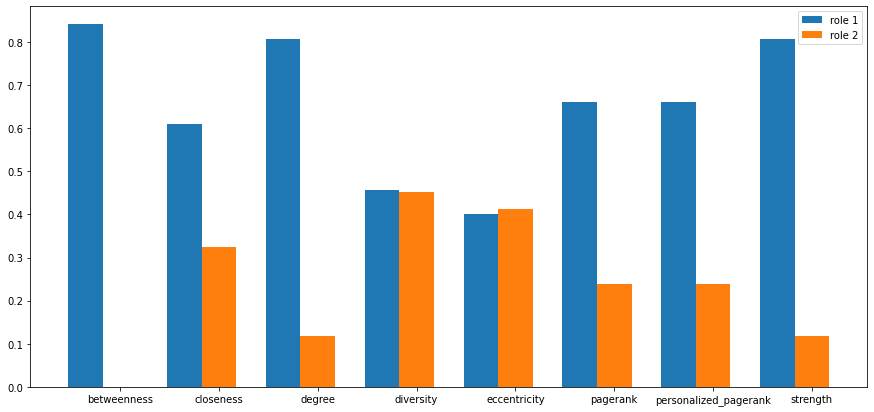

In [38]:
features = [ 'betweenness', 'closeness', 'degree', 'diversity', 'eccentricity', 'pagerank', 'personalized_pagerank', 'strength' ]
n_features = len(features)

index = np.arange(n_features)
bar_width = .35

plt.figure(figsize=(15,7))

rect1 = plt.bar(index, np.asarray(K[0,:]).flatten(), bar_width, label='role 1')
rect2 = plt.bar(index+bar_width, np.asarray(K[1,:]).flatten(), bar_width, label='role 2')

plt.legend()
plt.xticks(index+bar_width, features)
plt.show()